# 4. Semantic Space Construction

In this notebook, the semantic space is constructed by which nouns in the Hebrew Bible can be compared for similarity. The steps are:

1) Gather data in the Hebrew Bible for all nouns in narrative clauses that function either as a subject, object, or coordinate noun within a subj/obj phrase. Another restriction is applied that requires the noun have a minimum occurrence frequency. For every noun that meets these requirements, record the verb or noun that it collocates with. Also record the target noun's role and the collocated word's role. E.g. "Subject -> verb" or "Subject -> coordinate.noun." In addition, for every verb the stem is also recorded. An example of a full tag is: "Subj -> HLK[.qal" (הלך in the qal). 

2) Apply frequency adjustments to all of the cooccurrence counts. Since different words in a text occur with many different frequencies, statistical adjustments are commonly used in semantic space constructions. This notebook experiments with the [log-likelihood](http://aclweb.org/anthology/J93-1003) and [pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information#Applications) scores. 

3) Apply [principle component analysis](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/) (PCA) to compress all of the data points (cooccurrence counts) for each word into two, representative values. These values present the most informative "angle" from which to view the word cooccurrence data, i.e. the "angle" which presents the greatest amount of variation. PCA allows us to plot the words on a graph and visually inspect any potential clusters.

4) Apply similarity measures and clustering algorithms to group nouns together. Similarity measures are algorithms which compare the data for all nouns with each other to determine a distance. In other words, it calculates how similar the terms are to each other. A [clustering algorithm](https://en.wikipedia.org/wiki/Cluster_analysis) can use these distances to group the nouns into different clusters. A silhouette diagram can be used for partioning cluster methods to determine the ideal number of clusters (`k`). 

The results in this notebook are exploratory and rough. There are a few points of improvement that are needed going forward. For step 1, a more sophisiticated system of context selection must be designed. The system should not only consider predicate/object/subject/coordinate relations, but also complements and other descriptors (e.g. constructs, adjectives, adverbs, etc.). In [Padó and Lapata 2007](https://www.mitpressjournals.org/doi/pdf/10.1162/coli.2007.33.2.161), the inspiration for this experiment, a variety of paths and relationships are considered using a dependency tree. Dependency trees describe the precise relationships between words within a clause. For instance, a clause's verb is in a relation with its object; descriptors such as adjectives are in dependent relations with their described nouns, etc.. The ETCBC data does not contain such fine-grained encodings. But there is an ETCBC [tree module](https://github.com/ETCBC/lingo) (Dirk Roorda) which contains constituency trees in [Penn Treebank](https://en.wikipedia.org/wiki/Treebank) format. These trees may be useful for approximating the Padó and Lapata method. 

## Load Functions

In [1]:
import collections, os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import pairwise_distances
os.sys.path.append('../')
from project_code.semspace import P1SemSpace

# Build Semantic Space

Import SemSpace, the class which contains the code for all of the experiments. This class is also easily maneuverable for alternate experiment parameters.

In [2]:
semspace = P1SemSpace()

# give report on space size
print('Size of the space:')
for name, count in zip(('cooccurrences', 'target words'), semspace.raw.shape):
    print('\t', count, name)

Size of the space:
	 502 cooccurrences
	 109 target words


### Import BHSA Helpers & Text-Fabric

In [3]:
get_lex = semspace.get_lex # returns a lex node
F, T, L = semspace.tf_api.F, semspace.tf_api.T, semspace.tf_api.L # Text Fabric api with BHSA data

### Raw and Adjusted Frequency Matrices

In [4]:
# Adjusted Counts (and raw counts)
cooccurrences = semspace.raw
test_ll = semspace.loglikelihood
test_pmi = semspace.pmi

# give e.g.
test_ll.head(5)

,<BD/,<DH/,<JN/,<JR/,<LH/,<LJH/,<M/,<MWD/,<Y/,>B/,...,TMRH/,TWL<T/,XJL/,XMWR/,XRB/,XSD/,XWMH/,Y>N/,ZHB/,ZR</
Objc.<BD[.hif,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Objc.<BD[.qal,3.087921,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,3.717084,0.0,0.0,0.0,0.0,0.000000,0.0
Objc.<BR[.hif,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Objc.<BR[.qal,0.000000,0.0,0.0,0.0,0.0,0.0,2.631905,0.000000,0.000000,0.0,...,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
Objc.<FH[.qal,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2.075579,1.164509,0.0,...,0.0,0.67423,0.0,0.000000,0.0,0.0,0.0,0.0,6.184645,0.0


## Size of Observations

### Raw Frequencies

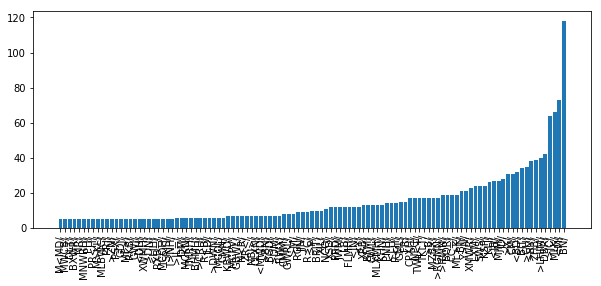

In [5]:
plt.figure(figsize=(10, 4))
plt.bar(cooccurrences.sum().sort_values().index, cooccurrences.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### Log Likelihood Adjusted Frequencies

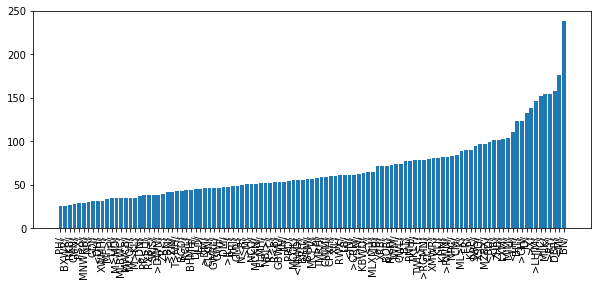

In [6]:
plt.figure(figsize=(10, 4))
plt.bar(test_ll.sum().sort_values().index, test_ll.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### PMI Adjusted Frequencies

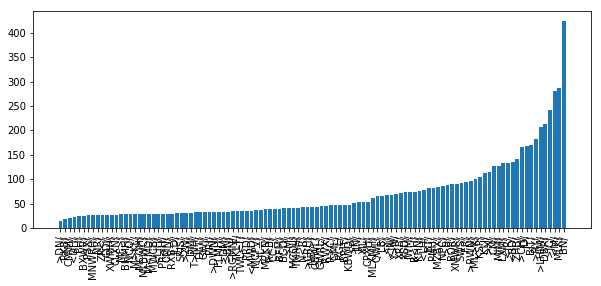

In [7]:
plt.figure(figsize=(10, 4))
plt.bar(test_pmi.sum().sort_values().index, test_pmi.sum().sort_values().values)
plt.xticks(rotation='vertical')
plt.show()

### Top Counts

Examine the top counts to see how the frequency adjustments affect the overal values.

**Top Raw Counts**

In [8]:
cooccurrences.sum().sort_values(ascending=False).head(10)

BN/       118.0
<M/        73.0
MLK/       66.0
>JC/       64.0
DBR/       42.0
>LHJM/     40.0
ZHB/       39.0
>RY/       38.0
>CH/       35.0
BJT/       34.0
dtype: float64

**Top Log-likelihood**

In [9]:
test_ll.sum().sort_values(ascending=False).head(10)

BN/       238.054854
<M/       175.719832
DBR/      157.021869
>RY/      154.333688
MLK/      154.092884
>JC/      152.025253
>LHJM/    146.386701
>X/       138.198527
JD/       132.179147
>CH/      122.838788
dtype: float64

**Top PMI counts**

In [10]:
test_pmi.sum().sort_values(ascending=False).head(10)

BN/       423.957141
MLK/      287.631996
<M/       280.059850
>JC/      241.940455
DBR/      212.388798
>LHJM/    206.897953
>RY/      182.556280
BJT/      171.003419
JD/       168.048682
>CH/      166.086614
dtype: float64

## Vector Space Construction with PCA

Use Principal Component Analysis (PCA) to look at the data.

### PCA Assignments from SemSpace

In [11]:
pca_raw = semspace.pca_raw
pca_ll = semspace.pca_ll
pca_pmi = semspace.pca_pmi

### PCA with Raw Counts

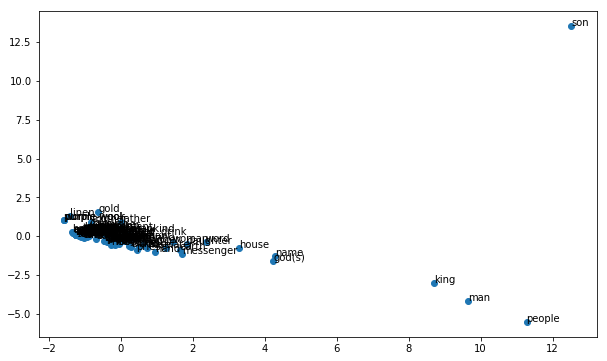

In [12]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in cooccurrences.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_raw[i, 0], pca_raw[i, 1]))

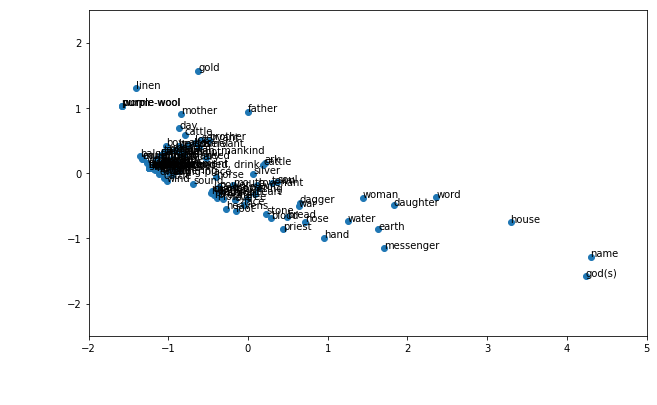

In [115]:
# Closer view of the raw counts PCA
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_raw[:, 0], pca_raw[:, 1])

plt.axis([-2, 5, -2.5, 2.5])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in cooccurrences.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_raw[i, 0], pca_raw[i, 1]))

### PCA with Log-likelihood (G test)

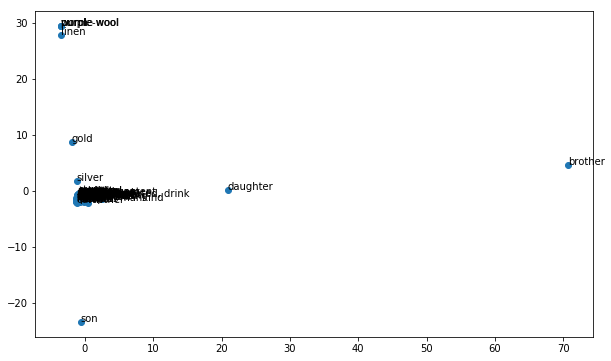

In [13]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

# annotate
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=10)
    
plt.savefig('images/ll_space.png')

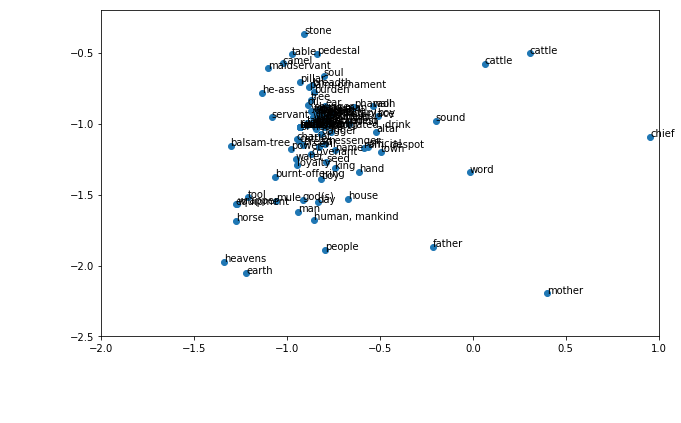

In [14]:
# closer view of LL
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_ll[:, 0], pca_ll[:, 1])

plt.axis([-2, 1, -2.5, -0.2])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_ll.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_ll[i, 0], pca_ll[i, 1]), fontsize=10)
    
plt.savefig('images/ll_space_zoom.png')

#### LL, 3D Plot

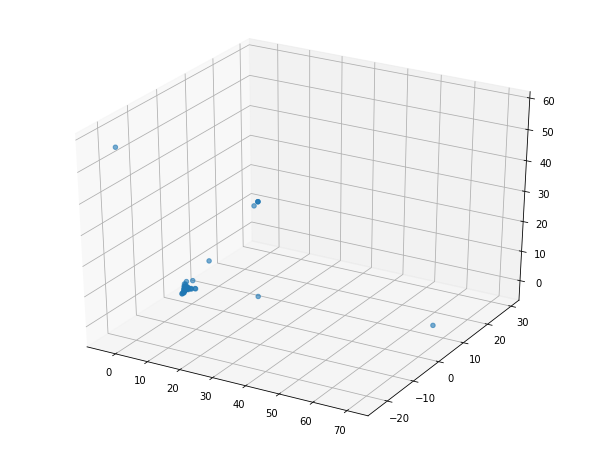

In [15]:
pca_ll_3D = semspace.pca_ll_3d

x = pca_ll_3D[:, 0]
y = pca_ll_3D[:, 1]
z = pca_ll_3D[:, 2]
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)

ax.scatter(x, y, z, marker='o', alpha=0.6)
    
plt.show()

### PCA with Pointwise Mutual Information

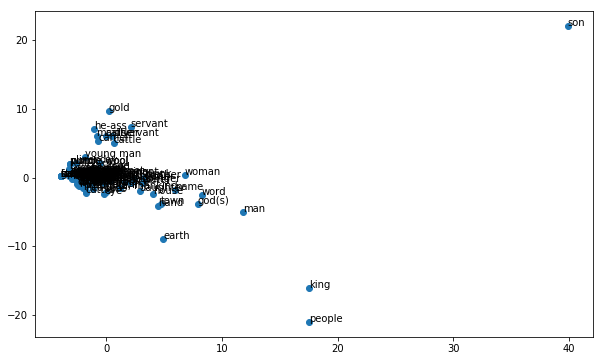

In [105]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_pmi.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_pmi[i, 0], pca_pmi[i, 1]))

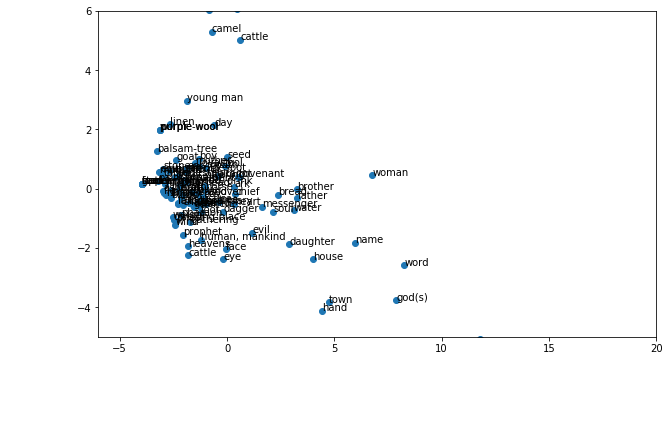

In [106]:
# create a scatter plot of the projection
plt.figure(1, figsize=(10, 6))
plt.scatter(pca_pmi[:, 0], pca_pmi[:, 1])

#plt.axis([-1, 2, -3, 5])
plt.axis([-6, 20, -5, 6])

# annotate 
words = [F.gloss.v(get_lex(l)) for l in test_pmi.columns]
for i, word in enumerate(words):
    plt.annotate(word, xy=(pca_pmi[i, 0], pca_pmi[i, 1]))

## Distances and Similarities

Use cosine similarity to construct a similarity matrix. Export a set of similarity sets.

In [121]:
row_col = [F.lex.v(get_lex(w)) + ' (' + F.gloss.v(get_lex(w)) + ')' for w in cooccurrences.columns]

# distances, non-pca
ll_dists = pairwise_distances(test_ll.T.values, metric='cosine')
pmi_dists = pairwise_distances(test_pmi.T.values, metric='cosine')
raw_dists = pairwise_distances(cooccurrences.T.values, metric='cosine')

# distances, pca
pca_dists_ll = pairwise_distances(pca_ll, metric='euclidean')
pca_dists_pmi = pairwise_distances(pca_pmi, metric='euclidean')
pca_dists_raw = pairwise_distances(pca_raw, metric='euclidean')

# distance matrices
ll_dist_matrix = pd.DataFrame(ll_dists, columns=row_col, index=row_col)
pmi_dist_matrix = pd.DataFrame(pmi_dists, columns=row_col, index=row_col)
raw_dist_matrix = pd.DataFrame(raw_dists, columns=row_col, index=row_col)
pca_ll_dist_matrix = pd.DataFrame(pca_dists_ll, columns=row_col, index=row_col)
pca_pmi_dist_matrix = pd.DataFrame(pca_dists_pmi, columns=row_col, index=row_col)


# similarity matrices
ll_sim_matrix = ll_dist_matrix.apply(lambda x: 1-x)
pmi_sim_matrix = pmi_dist_matrix.apply(lambda x: 1-x)
raw_sim_matrix = raw_dist_matrix.apply(lambda x: 1-x)

In [124]:
pca_ll_dist_matrix['CMJM/ (heavens)'].sort_values()[1:].head()

>RY/ (earth)        0.147602
SWS/ (horse)        0.295651
NCQ/ (equipment)    0.409105
FLMH/ (wrapper)     0.414699
KLJ/ (tool)         0.472627
Name: CMJM/ (heavens), dtype: float64

### Export Word Similarity Lists to data/{method} directories

In [127]:
for method, matrix in (('ll', ll_sim_matrix), 
                       ('pmi', pmi_sim_matrix), 
                      ):
        
    for noun in matrix.index:
        
        data_dir = f'data/{method}'
        
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)
                
        name = noun.replace('/', '').replace('\\', '')
        word_path = os.path.join(data_dir, f'{name}.csv')
        matrix[noun].sort_values(ascending=False)[1:].to_csv(word_path)

print('done!')

done!


In [128]:
for method, matrix in (('ll_pca', pca_ll_dist_matrix), 
                       ('pmi_pca', pca_pmi_dist_matrix), 
                      ):
        
    for noun in matrix.index:
        
        data_dir = f'data/{method}'
        
        if not os.path.exists(data_dir):
            os.mkdir(data_dir)
                
        name = noun.replace('/', '').replace('\\', '')
        word_path = os.path.join(data_dir, f'{name}.csv')
        matrix[noun].sort_values()[1:].to_csv(word_path)

print('done!')

done!
